# PCA-eval : evaluating Principal Component Analysis (PCA) performance in high-dimensional data

I created this simple package to evaluate whether PCA sucessfully carries most of the data variance in single-cell genomics. It should work for any high-dimensional data. In a nutshell, this helps practitioners evaluate whether they can perform PCA for denoising and reduction of computational burden before proceeding with sophisticated non-linear methods.

Let's start to see how to use this package with some simple simulated data:

In [1]:
from pcaeval.pca_eval import (generate_linear_data,
                              generate_uncorrelated_data,
                              evaluate_matrix,
                              plot_sing_vals_exp_var)

We'll simulate linearly correlated data and uncorrelated data to validate the analysis pipeline.

In [2]:
linear_test = generate_linear_data(n=10000, d=2000, n_classes=10, redundancy=0.1, noise=0.1, seed=0)
uncorrelated_test = generate_uncorrelated_data(n=10000, d=2000, seed=0)

datasets = {'Linear data':linear_test, 'Uncorrelated data':uncorrelated_test}

Next, we'll evaluate these data matrices with our `evaluate_matrix()` function. It yields a dictionary of results.

In [3]:
results_dict = {}
for i_data, name in enumerate(datasets):
    r_dict = evaluate_matrix(
        datasets[name], n_pcs=100, dimred_estimator=False,
     clustering_estimator=False, n_jobs=-1, verbose=True
     )
    results_dict[name] = r_dict

No precomputed kNN graph specified, computing...
No precomputed kNN graph specified, computing...


Finally, let's plot the covariance eigenspectrum (singular values and cumulative explained variance):

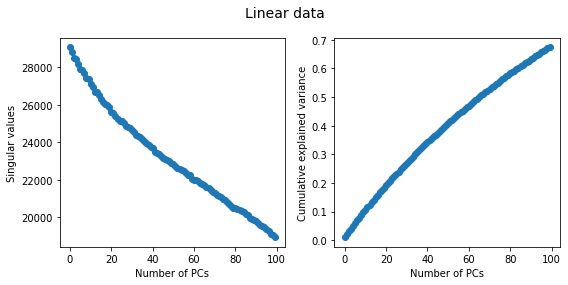

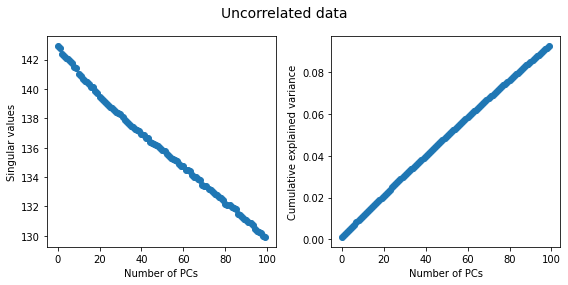

In [4]:
plot_sing_vals_exp_var(results_dict, fontsize=10)

As one can see, PCs carry little to no variance and fail to meaningfully represent the data when it is not linearly correlated.

An example of how this can be important is neighborhood graph construction: often practitioners learn nearest-neighbors graphs on top PCs instead of using the full data. These two nearest-neighbors graphs are poorly correlated when data is not linearly correlated:

In [5]:
print('Spearman R correlation the k-nearest-neighbors graphs learned from the data and the Principal Components:' +
'\n Linear data: %f'%results_dict['Linear data']['graph_correlation'] + '\n Uncorrelated data: %f'%results_dict['Uncorrelated data']['graph_correlation'])

Spearman R correlation the k-nearest-neighbors graphs learned from the data and the Principal Components:
 Linear data: 0.611320
 Uncorrelated data: 0.188518


Thus, as we can see, building the k-nearest-neighbors graph from PCs when data features are not linearly correlated is often a bad idea. The same goes for other algorithms with locality-preserving characteristics, such as non-linear dimensional reduction.

Let's see how this goes for UMAP, a very popular dimensional reduction technique. We'll use K-means for clustering, since we know the number of clusters beforehand in this simulated data. Any method can be evaluated within `pca-eval`, but we currently expect dimensional reduction methods  to have a `.fit_transform(X)` method and clustering methods to have a `.fit_predict(X)` method. If no method is provided, `pca-eval` will use t-SNE and Affinity Propagation by default.

In [6]:
# Install umap if you don't have it (c'mon, you should already have it, its fabulous)
#%pip install umap-learn

In [7]:
from umap import UMAP
from sklearn.cluster import KMeans

umap_estimator = UMAP(n_neighbors=10, min_dist=0.3, n_components=2, random_state=42)
kmeans_estimator = KMeans(n_clusters=10)

results_dict = {}
for i_data, name in enumerate(datasets):
    r_dict = evaluate_matrix(
        datasets[name], n_pcs=100, dimred_estimator=umap_estimator,
     clustering_estimator=kmeans_estimator, n_jobs=-1, verbose=True
     )
    results_dict[name] = r_dict

No precomputed kNN graph specified, computing...
No precomputed kNN graph specified, computing...


In [8]:
linear_dict = results_dict['Linear data']
uncorrelated_dict = results_dict['Uncorrelated data']

print('Linear data :' +
 '\n Total explained variance with the first 100 PCs: %f'%linear_dict['explained_variance'].max() +
 '\n Spearman R correlation between the k-nearest-neighbors graphs learned from the data and the Principal Components: %f'%linear_dict['graph_correlation'] +
 '\n Spearman R correlation between the geodesic distances in UMAP embeddings learned from these graphs %f'%linear_dict['embedding_correlation'] +
 '\n Adjusted rand index (ARI) between clustering on top 100 PCs and on full data: %f'%linear_dict['adjusted_rand_score'])

print('\n \n Uncorrelated data :' +
 '\n Total explained variance with the first 100 PCs: %f'%uncorrelated_dict['explained_variance'].max() +
 '\n Spearman R correlation between the k-nearest-neighbors graphs learned from the data and the Principal Components: %f'%uncorrelated_dict['graph_correlation'] +
 '\n Spearman R correlation between the geodesic distances in UMAP embeddings learned from these graphs %f'%uncorrelated_dict['embedding_correlation'] +
 '\n Adjusted rand index (ARI) between clustering on top 100 PCs and on full data: %f'%uncorrelated_dict['adjusted_rand_score'])

Linear data :
 Total explained variance with the first 100 PCs: 0.674300
 Spearman R correlation between the k-nearest-neighbors graphs learned from the data and the Principal Components: 0.619191
 Spearman R correlation between the geodesic distances in UMAP embeddings learned from these graphs 0.032093
 Adjusted rand index (ARI) between clustering on top 100 PCs and on full data: 0.106320

 
 Uncorrelated data :
 Total explained variance with the first 100 PCs: 0.092597
 Spearman R correlation between the k-nearest-neighbors graphs learned from the data and the Principal Components: 0.188802
 Spearman R correlation between the geodesic distances in UMAP embeddings learned from these graphs 0.001126
 Adjusted rand index (ARI) between clustering on top 100 PCs and on full data: -0.004558


Now let's see how this goes in single-cell genomics:

In [9]:
import scanpy as sc
from pcaeval.pca_eval import evaluate_anndata, plot_sing_vals_exp_var
adata = sc.datasets.pbmc3k()

# Input: a filtered, unnormalized AnnData object
# If already normalized, set norm_log_hvg=False
res_dict, adata = evaluate_anndata(adata, norm_log_hvg=True)

  0%|          | 0.00/5.58M [00:00<?, ?B/s]

In [10]:
print(' --- PBMC3K ---' +
 '\n Total explained variance with the first 100 PCs: %f'%res_dict['explained_variance'].max() +
 '\n Spearman R correlation between the k-nearest-neighbors graphs learned from the data and the Principal Components: %f'%res_dict['graph_correlation'] +
 '\n Spearman R correlation between the geodesic distances in UMAP embeddings learned from these graphs %f'%res_dict['embedding_correlation'] +
 '\n Adjusted rand index (ARI) between clustering on top 100 PCs and on full data: %f'%res_dict['adjusted_rand_score'])

 --- PBMC3K ---
 Total explained variance with the first 100 PCs: 0.206206
 Spearman R correlation between the k-nearest-neighbors graphs learned from the data and the Principal Components: 0.110801
 Spearman R correlation between the geodesic distances in UMAP embeddings learned from these graphs 0.028276
 Adjusted rand index (ARI) between clustering on top 100 PCs and on full data: 0.238680


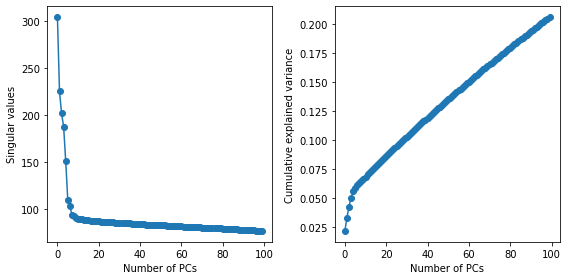

In [11]:
plot_sing_vals_exp_var(res_dict, dataset=False, fontsize=10)
# datset=False means that the dictionary is not a dictionary of dictionaries with multiple datasets, but
# a dictionary with results from a single dataset

As easily observed, single-cell genomics data should be considered as not having linearly correlated variables. Thus, PCA is unsuited for its preprocessing or analysis unless proven otherwise. 

----------
NOTICE: 
As a matter of fact, nearly all published literature in single-cell genomics uses PCA for processing, so one cannot rigorously trust any of it. As despairing as this might seem, I see this as an opportunity for the community to do better rather than just following tutorials from toolkits such as Seurat and Scanpy (which do PCA preprocessing by default). It is also an opportunity to work together as a community, since all of this data will need to be reanalysed so that artifacts and distortions can be identified.

One may wonder how the communitty allowed it to come to this. I believe the answer lies somewhere between the unwillingness to address mistakes in disregard of how malicious they might be for science and the inability to question whether what is done by all is actually correct.